In [ ]:
# https://www.kaggle.com/competitions/ashrae-energy-prediction/overview

# Load Packages and Import Data

In [1]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

pd.options.display.float_format = '{:.2f}'.format

In [2]:
# Find our directory
directory = !dir
for d in directory:
    if "Directory" in d:
        path = d[14:]
path = path.replace('\\', '/')

# read each table to dataframe
all_data = {}

for f in glob.glob(f"{path}/ashrae-energy-prediction/*"):
    filename=f.split("\\")[1][:-4]
    file_path = f"{path}/ashrae-energy-prediction/{filename}.csv"
    file_size = os.path.getsize(file_path)

    print(f"File/Size: {filename} / {file_size/1024/1024:.1f} MB")    
    
    df = pd.read_csv(f"{file_path}")
    all_data[filename] = df

all_data.keys()

File/Size: building_metadata / 0.0 MB
File/Size: sample_submission / 426.8 MB
File/Size: test / 1394.7 MB
File/Size: train / 647.2 MB
File/Size: weather_test / 14.1 MB
File/Size: weather_train / 7.1 MB


dict_keys(['building_metadata', 'sample_submission', 'test', 'train', 'weather_test', 'weather_train'])

In [20]:
df_meta = all_data['building_metadata']
df_train = all_data['train']
df_test = all_data['test']
df_w_train = all_data['weather_train']
df_w_test = all_data['weather_test']
df_sample = all_data['sample_submission']

df_train['timestamp'] = pd.to_datetime(df_train['timestamp'])
df_test['timestamp'] = pd.to_datetime(df_test['timestamp'])

In [4]:
# Define standard functions

# Temperature Conversions
def FtoC(F):
    return (F-32)*5/9

def CtoF(C):
    return (9/5)*C+32

# Value count and %
def vc(df, feature):
    value_counts = df[feature].value_counts()
    value_percentages = df[feature].value_counts(normalize=True) * 100.0
    cumulative_percentages = value_percentages.cumsum()
    result = pd.DataFrame({'Count': value_counts, 'Percentage': value_percentages, 'Cumulative Percentage': cumulative_percentages})
    return result

# For each category in feature 1, get unique categories of feature 2
def unique_for_each_category(df,feature1, feature2):
    df1 = df[[feature1, feature2]].groupby(by = feature1, as_index=False).agg(lambda x: list(x))
    df1['unique'] = df1[feature2].apply(lambda x:set(x))
    df1['unique_length'] = df1['unique'].apply(lambda x:len(x))
    return df1    

# General Overview

In [5]:
display(df_meta.describe())
display(df_meta.info())
display(df_meta.head())

# 15 sites for 1449 buildings
# 1449 - 675 null data for year-built
# 1449 - 355 null data for floor count

,site_id,building_id,square_feet,year_built,floor_count
count,1449.00,1449.00,1449.00,675.00,355.00
mean,6.95,724.00,92111.78,1967.96,3.74
std,5.00,418.43,110769.95,31.05,3.33
min,0.00,0.00,283.00,1900.00,1.00
25%,3.00,362.00,23012.00,1949.00,1.00
50%,5.00,724.00,57673.00,1970.00,3.00
75%,13.00,1086.00,115676.00,1995.00,5.00
max,15.00,1448.00,875000.00,2017.00,26.00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   site_id      1449 non-null   int64  
 1   building_id  1449 non-null   int64  
 2   primary_use  1449 non-null   object 
 3   square_feet  1449 non-null   int64  
 4   year_built   675 non-null    float64
 5   floor_count  355 non-null    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 68.0+ KB


None

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.00,NaN
1,0,1,Education,2720,2004.00,NaN
2,0,2,Education,5376,1991.00,NaN
3,0,3,Education,23685,2002.00,NaN
4,0,4,Education,116607,1975.00,NaN


In [6]:
display(df_train.describe())
display(df_train.info())
display(df_train.head())

display(df_test.describe())
display(df_test.info())
display(df_test.head())

,building_id,meter,meter_reading
count,20216100.00,20216100.00,20216100.00
mean,799.28,0.66,2117.12
std,426.91,0.93,153235.62
min,0.00,0.00,0.00
25%,393.00,0.00,18.30
50%,895.00,0.00,78.78
75%,1179.00,1.00,267.98
max,1448.00,3.00,21904700.00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 4 columns):
 #   Column         Dtype  
---  ------         -----  
 0   building_id    int64  
 1   meter          int64  
 2   timestamp      object 
 3   meter_reading  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 616.9+ MB


None

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.00
1,1,0,2016-01-01 00:00:00,0.00
2,2,0,2016-01-01 00:00:00,0.00
3,3,0,2016-01-01 00:00:00,0.00
4,4,0,2016-01-01 00:00:00,0.00


,row_id,building_id,meter
count,41697600.00,41697600.00,41697600.00
mean,20848799.50,807.58,0.66
std,12037060.44,429.77,0.93
min,0.00,0.00,0.00
25%,10424399.75,404.75,0.00
50%,20848799.50,900.00,0.00
75%,31273199.25,1194.25,1.00
max,41697599.00,1448.00,3.00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41697600 entries, 0 to 41697599
Data columns (total 4 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   row_id       int64 
 1   building_id  int64 
 2   meter        int64 
 3   timestamp    object
dtypes: int64(3), object(1)
memory usage: 1.2+ GB


None

,row_id,building_id,meter,timestamp
0,0,0,0,2017-01-01 00:00:00
1,1,1,0,2017-01-01 00:00:00
2,2,2,0,2017-01-01 00:00:00
3,3,3,0,2017-01-01 00:00:00
4,4,4,0,2017-01-01 00:00:00


In [7]:
display(df_w_train.describe())
display(df_w_train.info())
display(df_w_train.head())

display(df_w_test.describe())
display(df_w_test.info())
display(df_w_test.head())

,site_id,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
count,139773.00,139718.00,70600.00,139660.00,89484.00,129155.00,133505.00,139469.00
mean,7.48,14.42,2.15,7.35,0.98,1016.16,180.53,3.56
std,4.60,10.63,2.60,9.79,8.46,7.63,111.52,2.34
min,0.00,-28.90,0.00,-35.00,-1.00,968.20,0.00,0.00
25%,3.00,7.20,0.00,0.60,0.00,1011.80,80.00,2.10
50%,7.00,15.00,2.00,8.30,0.00,1016.40,190.00,3.10
75%,11.00,22.20,4.00,14.40,0.00,1020.80,280.00,5.00
max,15.00,47.20,9.00,26.10,343.00,1045.50,360.00,19.00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   site_id             139773 non-null  int64  
 1   timestamp           139773 non-null  object 
 2   air_temperature     139718 non-null  float64
 3   cloud_coverage      70600 non-null   float64
 4   dew_temperature     139660 non-null  float64
 5   precip_depth_1_hr   89484 non-null   float64
 6   sea_level_pressure  129155 non-null  float64
 7   wind_direction      133505 non-null  float64
 8   wind_speed          139469 non-null  float64
dtypes: float64(7), int64(1), object(1)
memory usage: 9.6+ MB


None

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.00,6.00,20.00,NaN,1019.70,0.00,0.00
1,0,2016-01-01 01:00:00,24.40,NaN,21.10,-1.00,1020.20,70.00,1.50
2,0,2016-01-01 02:00:00,22.80,2.00,21.10,0.00,1020.20,0.00,0.00
3,0,2016-01-01 03:00:00,21.10,2.00,20.60,0.00,1020.10,0.00,0.00
4,0,2016-01-01 04:00:00,20.00,2.00,20.00,-1.00,1020.00,250.00,2.60


,site_id,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
count,277243.00,277139.00,136795.00,276916.00,181655.00,255978.00,264873.00,276783.00
mean,7.48,14.28,2.19,7.49,1.10,1016.20,180.43,3.55
std,4.62,10.74,2.62,10.15,9.16,7.94,110.46,2.32
min,0.00,-28.10,0.00,-31.60,-1.00,972.00,0.00,0.00
25%,3.00,7.20,0.00,0.60,0.00,1011.60,80.00,2.10
50%,7.00,15.00,2.00,8.40,0.00,1016.30,190.00,3.10
75%,12.00,22.20,4.00,15.00,0.00,1020.80,280.00,4.60
max,15.00,48.30,9.00,26.70,597.00,1050.10,360.00,24.20


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277243 entries, 0 to 277242
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   site_id             277243 non-null  int64  
 1   timestamp           277243 non-null  object 
 2   air_temperature     277139 non-null  float64
 3   cloud_coverage      136795 non-null  float64
 4   dew_temperature     276916 non-null  float64
 5   precip_depth_1_hr   181655 non-null  float64
 6   sea_level_pressure  255978 non-null  float64
 7   wind_direction      264873 non-null  float64
 8   wind_speed          276783 non-null  float64
dtypes: float64(7), int64(1), object(1)
memory usage: 19.0+ MB


None

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2017-01-01 00:00:00,17.80,4.00,11.70,NaN,1021.40,100.00,3.60
1,0,2017-01-01 01:00:00,17.80,2.00,12.80,0.00,1022.00,130.00,3.10
2,0,2017-01-01 02:00:00,16.10,0.00,12.80,0.00,1021.90,140.00,3.10
3,0,2017-01-01 03:00:00,17.20,0.00,13.30,0.00,1022.20,140.00,3.10
4,0,2017-01-01 04:00:00,16.70,2.00,13.30,0.00,1022.30,130.00,2.60


In [8]:
## Questions for Meta Data
# What's the distribution of primary_use? 
# Do buildings and site have the same primary use?   doubt it...
# What's the average square feet for each primary use type? 
# Are there any correlations between each of these numerical features
# Can 2 or more sites have the same building ids?

## Questions for train/test data
# Are there correlations between meter and meter_reading? 
# what is distribution of meter type? (value counts)
# Idea, do we need 4 models, 1 for each meter?
# Idea, do we need to cluster building_id's and create separate models?  
# Feature Idea, energy per sqft to help with clustering of buildings
# Are the same building_id in train and test data?  Or will we predict new buildngs?
# What is the range of timestamp for train versus test data?
# What is the frequency of timestamp for train versus test data?  Is it every 15 minutes? every hour? 

## Questions for Weather data
# Do we need to consider climate change?  Would weather data drift in future affect model?
# airtemp: Which require more energy?  +10C from normal or -10C from normal?       19C to 24C  = normal human comfort temp
print(FtoC(65))  #65F to 75F = very little heating/cooling
print(FtoC(75))  #65F to 75F = very little heating/cooling
print(CtoF(-29))  
print(CtoF(47))  #arizona???
# cloud: confirm: high cloud + high air temp = low energy.  low cloud + low air temp = low energy.  Vice versa
# dew temp: if dew = air, = high humidity.  = more energy
# precip: high precip = low energy?  
# how does sea level pressure affect energy?  google research this
# how does wind direction affect energy?  gooogle sesarch this
# wind speed: high speed = low energy if hot and high energy if cold
# Feature idea: dew temp / air temp or dew temp - air temp
# What is the range of timestamp for train versus test data?
# What is the frequency of timestamp for train versus test data?  Is it every 15 minutes? every hour?

18.333333333333332
23.88888888888889
-20.200000000000003
116.60000000000001


## Meta Data

In [16]:
df_meta.head(1)

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,"2,008",NaN


In [10]:
### What's the distribution of primary_use?   
### ANS:  mostly Education, then Offices, Entertainment/public assembly, public services.  These make up 80% of buildings.  
df_meta_primaryuse_vc = vc(df_meta, 'primary_use')
display(df_meta_primaryuse_vc)

,Count,Percentage,Cumulative Percentage
Education,549,37.89,37.89
Office,279,19.25,57.14
Entertainment/public assembly,184,12.70,69.84
Public services,156,10.77,80.61
Lodging/residential,147,10.14,90.75
Other,25,1.73,92.48
Healthcare,23,1.59,94.06
Parking,22,1.52,95.58
Warehouse/storage,13,0.90,96.48
Manufacturing/industrial,12,0.83,97.31


In [11]:
### Do buildings and site have the same primary use?   doubt it...  

# Check if sites have multiple primary use types.  ANS: Sites have multiple primary use types
sid = df_meta.site_id.sample(1).values[0] #randomly sample a site
print(f'Site {sid} unique primary use types: {df_meta[df_meta.site_id==sid].primary_use.unique()} \n')

# Check if buildings have multiple primary use types.  ANS: Buildings only have 1 primary use type
for bid in range(df_meta.building_id.nunique()):                 
    unique_primaryuse = df_meta[df_meta.building_id==bid].primary_use.unique()
    
    # if each building has more than 1 or less than 1 primary use type, print the building id.  Else, all buildings have only 1 primary use type.
    if len(unique_primaryuse) > 1:
        print(f'Building {bid} unique primary use types: {unique_primaryuse}')
    elif len(unique_primaryuse) < 1:
        print(f'Building {bid} unique primary use types: {unique_primaryuse}')

Site 15 unique primary use types: ['Entertainment/public assembly' 'Office' 'Education' 'Technology/science'
 'Public services' 'Manufacturing/industrial' 'Religious worship'
 'Lodging/residential' 'Utility' 'Healthcare'] 



In [12]:
# What's the average square feet for each primary use type? 
# ANS: ON AVERAGE:
# Parking is largest followed by Services, Healthcare, and Education. Religious worship is smallest
# 1939 (Technology/science is oldest) through 2012 (Food sales and service)   <---- may want to bin on building age...
# Floors range from 1 to 6.  <-- may want to bin 1 floor versus multiple floor.  1 floor has roof load.  2 floor, roof load splits to 2....  

pd.options.display.float_format = '{:,.0f}'.format
primary_use_types = df_meta.primary_use.unique()

primary_use_types_dict = dict()
primary_use_types_dict['Primary Use'] = []
primary_use_types_dict['# of Buildings'] = []
primary_use_types_dict['Avg Square Feet'] = []
primary_use_types_dict['Avg Year Built'] = []
primary_use_types_dict['Avg Floor Count'] = []

for put in primary_use_types:
    
    put_count = df_meta[df_meta.primary_use == put].building_id.nunique()
    mean_sf = round(df_meta[df_meta.primary_use == put].square_feet.mean(),0)
    mean_yrblt = round(df_meta[df_meta.primary_use == put].year_built.mean(),0)
    mean_flrcnt = round(df_meta[df_meta.primary_use == put].floor_count.mean(),0)
    
    primary_use_types_dict['Primary Use'].append(put)
    primary_use_types_dict['# of Buildings'].append(put_count)
    primary_use_types_dict['Avg Square Feet'].append(mean_sf)
    primary_use_types_dict['Avg Year Built'].append(mean_yrblt)
    primary_use_types_dict['Avg Floor Count'].append(mean_flrcnt)

pd.DataFrame(primary_use_types_dict)

,Primary Use,# of Buildings,Avg Square Feet,Avg Year Built,Avg Floor Count
0,Education,549,"104,329","1,963",5
1,Lodging/residential,147,"85,369","1,973",6
2,Office,279,"87,066","1,973",4
3,Entertainment/public assembly,184,"80,584","1,971",2
4,Other,25,"31,457","1,982",1
5,Retail,11,"39,298","1,998",2
6,Parking,22,"279,342","1,998",3
7,Public services,156,"64,947","1,964",2
8,Warehouse/storage,13,"45,584","1,983",1
9,Food sales and service,5,"38,485","2,012",NaN


In [13]:
# Can 2 or more sites have the same building ids?  

count=0
for sid_1 in range(df_meta.site_id.nunique()):
    for sid_2 in range(df_meta.site_id.nunique()):
        
        if sid_1 != sid_2:

            sid_1_bid = set(df_meta[df_meta.site_id==sid_1].building_id.unique())
            sid_2_bid = set(df_meta[df_meta.site_id==sid_2].building_id.unique())
            
            if len(sid_1_bid.intersection(sid_2_bid)) > 0:
                print(sid_1,sid_2)
                count += 1
if count == 0:       
    print('each building id only has one site id')


each building id only has one site id


In [14]:
df_meta.columns

Index(['site_id', 'building_id', 'primary_use', 'square_feet', 'year_built',
       'floor_count'],
      dtype='object')

<AxesSubplot:>

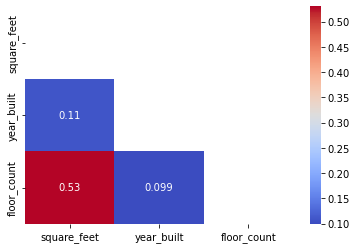

In [15]:
# Are there any correlations between each of these numerical features  
# ANS: floor count and square feet are pos correlation.
c = ['square_feet', 'year_built', 'floor_count']
mask = np.triu(np.ones_like(df_meta[c].corr(), dtype=bool))
sns.heatmap(df_meta[c].corr(), annot=True, cmap = 'coolwarm', mask=mask)

## Train/Test Data  

Meter: {0: electricity, 1: chilledwater, 2: steam, 3: hotwater}  

In [27]:
display(df_train.head(1))
display(df_test.head(1))

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01,0


,row_id,building_id,meter,timestamp
0,0,0,0,2017-01-01


In [65]:
# Are there correlations between meter and meter_reading? 
pd.options.display.float_format = '{:,.5f}'.format
c = ['meter', 'meter_reading']
print(df_train[c].corr())

                meter  meter_reading
meter         1.00000        0.01767
meter_reading 0.01767        1.00000


In [59]:
# what is distribution of meter type? (value counts)
# ANS: mostly electricity (60%).  Then chilled water. Then Steam. then hot water.
display(vc(df_train,'meter'))
display(vc(df_test,'meter'))

,Count,Percentage,Cumulative Percentage
0,12060910,60,60
1,4182440,21,80
2,2708713,13,94
3,1264037,6,100


,Count,Percentage,Cumulative Percentage
0,24755760,59,59
1,8724960,21,80
2,5676480,14,94
3,2540400,6,100


In [57]:
# Are the same building_id in train and test data?  Or will we predict new buildngs? ANS: SAME
train_bid = set(df_train.building_id.unique())
test_bid = set(df_test.building_id.unique())

print(f"{len(train_bid)} unique training building id's. {len(test_bid)} unique testing building id's") 
print(f"{len(train_bid.intersection(test_bid))} training and testing building id's are the same")

1449 unique training building id's. 1449 unique testing building id's
1449 training and testing building id's are the same


In [53]:
# What is the range of timestamp for train versus test data?
# What is the frequency of timestamp for train versus test data?  Is it every 15 minutes? every hour? 

# Distribution of training timestamp show 8784 unique values which is similar to 8784 hours in a year of 366 days. test data shows 17520 unique which is similar to 17520 hours in x2 365 day years.  
# ANS: Frequency is assumed to be 1 per hour.  Training ranges from 2016-01-01 through 2016-12-31 23 o'clock. Testing ranges from 2017-01-01 through 2018-12-31 23 o'clock. 
display(vc(df_train,'timestamp').sort_values(by='Count'))
display(vc(df_test,'timestamp').sort_values(by='Count'))

print(f"Training Min/Max Time Stamp: {df_train['timestamp'].min()}/{df_train['timestamp'].max()}")
print(f"Testing Min/Max Time Stamp: {df_test['timestamp'].min()}/{df_test['timestamp'].max()}")

# There are 1449 buildings for training and testing data with up to 4 meters. Max = 1449*4 = 5796 possible meter readings per hour.
print(df_train.building_id.nunique())  
print(df_test.building_id.nunique())

,Count,Percentage,Cumulative Percentage
2016-03-13 02:00:00,1557,0,100
2016-03-13 03:00:00,1767,0,100
2016-03-23 16:00:00,1822,0,100
2016-02-23 09:00:00,1871,0,100
2016-02-26 01:00:00,1887,0,100
...,...,...,...
2016-12-27 21:00:00,2369,0,0
2016-12-27 17:00:00,2369,0,0
2016-12-27 20:00:00,2369,0,0
2016-12-27 19:00:00,2369,0,0


,Count,Percentage,Cumulative Percentage
2017-01-01 00:00:00,2380,0,0
2017-01-02 09:00:00,2380,0,67
2017-01-01 16:00:00,2380,0,67
2017-01-01 02:00:00,2380,0,67
2017-01-01 03:00:00,2380,0,67
...,...,...,...
2018-12-31 09:00:00,2380,0,33
2018-12-30 15:00:00,2380,0,33
2018-12-31 08:00:00,2380,0,33
2018-12-31 13:00:00,2380,0,33


Training Min/Max Time Stamp: 2016-01-01 00:00:00/2016-12-31 23:00:00
Testing Min/Max Time Stamp: 2017-01-01 00:00:00/2018-12-31 23:00:00
1449
1449


In [ ]:
## Questions for train/test data
# Idea, do we need 4 models, 1 for each meter?
# Idea, do we need to cluster building_id's and create separate models?  
# Feature Idea, energy per sqft to help with clustering of buildings
# Idea, How do we check if electricity meter includes plug loads like computers or occupancy?  This generates heat too... helps in winter
# Idea, How do we check if hot water is just for heating/cooling or also to provide hot water for faucets or showers? 
